# Random Forest from the scratch (using dataset Adult from UCI)

A modifield version of a modifield version of:
Decision Tree from the Scratch, Rakend Dubba (Computational Engineer | Data Scientist).
*Source:* https://medium.com/@rakendd/decision-tree-from-scratch-9e23bcfb4928.

In this noteook, there is only a simple ensemble $M$ trees in a forest using soft volting.
The basic framework to run the training and testing steps was ready.

Done:

1) Using Bagging, get a group of $N_B$ random samples ($x_i, i = 1,... ,N_B$) with replacement for each three, for all $M$ trees.

2) Each tree with a maximum limit of $s_{MAX}$ splitlevels. Why there categorical features with more then two values, each level may have more then two nodes. *There is implemented the limit of splits trough each way, i.e., fallowing the same sequence till limit.

5) The ensembling model is based in voting, may possible to use both majority or soft. The schoice is made when using the predict funcion. *Rather that, it is use only soft voting.

The final version, we will have:

3) Each tree receive $K = s_{MAX}$ random features from all $p$ features.

4) There are two alternatives for splitting with numeric features: using entropy criteria and random splitting between max/min values. For categorical features, all values receive a node.

In [320]:
import re
import numpy as np
import pandas as pd
eps = np.finfo(float).eps
from numpy import log2 as log
from tabulate import tabulate as tb
from anytree import Node, RenderTree
from anytree import search as anys
from anytree.exporter import DotExporter
from IPython.display import Image

##### Load dataset:

In [330]:
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
            "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
            "Hours per week", "Country", "Target"]
train_data = pd.read_csv(
    #"https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "adult.data",
    names=features,
    sep=r'\s*,\s*',
    engine='python',
    na_values="?").dropna()

Target = 'Target'
Labels = train_data.Target.unique()
counts = train_data.Target.value_counts()
print(counts)

test_data = pd.read_csv(
    #"https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    "adult.test_fix",
    names=features,
    sep=r'\s*,\s*',
    skiprows=[0],
    engine='python',
    na_values="?").dropna()

Labels = test_data.Target.unique()
counts = test_data.Target.value_counts()
print(counts)


<=50K    22654
>50K      7508
Name: Target, dtype: int64
<=50K    11360
>50K      3700
Name: Target, dtype: int64


In [304]:
def find_entropy(df):
    entropy = 0
    values = df[Target].unique()
    for value in values:
        temp = df[Target].value_counts()[value]/len(df[Target])
        entropy += -temp*np.log2(temp)
    return entropy

def find_entropy_attribute(df,attribute):
    
    if not np.issubdtype(df[attribute].dtype, np.number):   
        return find_entropy_attribute_not_number(df,attribute), None
    else:
        return find_entropy_attribute_number(df,attribute)
          
        
def find_entropy_attribute_not_number(df,attribute):
    target_variables = df[Target].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        entropy2 += -(den/len(df))*entropy
    return abs(entropy2)


def find_entropy_attribute_number(df,attribute):
    target_variables = df[Target].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    variables.sort()
    if len(variables)>2:
        variables = variables[1:-1]
        vk3 = variables[0]
        entropy3 = 0
    else:
        vk3 = variables[0]
        entropy3 = np.Inf
    
    for vk in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]<=vk][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]<=vk])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]>vk][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]>vk])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        entropy2 = (den/len(df))*abs(entropy)
        #print(str(entropy2)+"|"+str(vk))
        if entropy2>entropy3:
            entropy3 = entropy2
            vk3 = vk
    return abs(entropy3),vk3

def find_winner(df):
    IG = []
    vk = list()
    for key in df.columns.difference([Target]):
        temp,temp2 = find_entropy_attribute(df,key)
        vk.append(temp2)
        IG.append(find_entropy(df)-temp)
    return df.columns.difference([Target])[np.argmax(IG)], vk[np.argmax(IG)]

def print_result_node(node,value,classe,prob):
    print(node +' : '+value+' : '+classe+' ('+str(prob)+')')

def buildtree(df,tree=None, mytree=None, T_pro=0.9, T_pro_num=0.6,total_splits=10,splits=1):
    
    def ramificatree(Thd,ss):
        if (len(clValue)==1):
            tree[node][value] = {}
            tree[node][value]['Class'] = clValue[0]
            tree[node][value]['Prob'] = 1.0
            #print_result_node(node,value,clValue[0],1)
        else:
            prob = counts.max() / counts.sum()
            if (prob>=Thd)or(splits>=total_splits):
                tree[node][value] = {}
                tree[node][value]['Class'] = clValue[counts.argmax()]
                tree[node][value]['Prob'] = prob
                #print_result_node(node,value,clValue[counts.argmax()],prob)
            else:
                ss += 1
                tree[node][value] = buildtree(subtable,splits=ss)
                #print(node +' : '+value+' : *')

    #print(find_winner(df))
    #formata_dados(dados)
    node,vk = find_winner(df)

    if tree is None:
        tree={}
        tree[node] = {}

    if vk is None:
        attValue = np.unique(df[node])
        for value in attValue:

            subtable = df[df[node] == value].reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)

            splits += 1
            ramificatree(T_pro,ss=splits)
    else:
        
        if (len(df[node][df[node] <= vk].unique())>0) and (len(df[node][df[node] > vk].unique())>0):
           
            # >vk
            value = node+' >'+str(vk)
            subtable = df[df[node] > vk].rename(columns = {node:value}).reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)            
            if (len(subtable[value].unique())==1) and (len(clValue)>1):
                tree[node][value] = {}
                tree[node][value]['Class'] = clValue[counts.argmax()]
                prob = counts.max() / counts.sum()
                tree[node][value]['Prob'] = prob
                #print_result_node(node,value,clValue[counts.argmax()],prob)
            else:
                splits += 1
                ramificatree(T_pro_num,ss=splits)
            clValue_antes = clValue[0]
            value_antes = value
            # <=vk
            value = node+' <='+str(vk)
            subtable = df[df[node] <= vk].rename(columns = {node:value}).reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)
            if ((len(subtable[value].unique())==1) and (len(clValue)>1)):
                tree[node][value] = {}
                tree[node][value]['Class'] = clValue[counts.argmax()]
                prob = counts.max() / counts.sum()
                tree[node][value]['Prob'] = prob
                #print_result_node(node,value,clValue[counts.argmax()],prob)
            else:
                splits += 1
                ramificatree(T_pro_num,ss=splits)

        else:
            df[node] = df[node].astype(str)
            buildtree(df)
        
    return tree


# Only to see

def print_tree(arg):
    for pre, fill, node in RenderTree(arg):
        print("%s%s" % (pre, node.name))
        
def converte_para_anytree(tree,node=None,mytree=None):
    
    if node is None:
        temp = list(tree.keys())
        node = temp[0]
        mytree = {}
        mytree[node] = Node(node)
        converte_para_anytree(tree,node,mytree)
    else:
        tree = tree[node]
        if not isinstance(tree, str):
            childs = list(tree.keys())
            for child in childs:
                if (list(tree[child])[0] == 'Class'):
                    temp = mytree[node]
                    mytree[child] = Node(child, parent=temp, target=tree[child]['Class'], prob=tree[child]['Prob'])
                else:
                    temp = mytree[node]
                    mytree[child] = Node(child, parent=temp)
                    converte_para_anytree(tree,child,mytree)
        else:
            mytree[node] = 'Fim'
                
    return mytree

#anys.findall_by_attr(mytree['Taste'], name="target", value='Yes')

def mostra_tree(tree):
    mytree = converte_para_anytree(tree)

    temp = list(tree.keys())
    root = temp[0]
    mytree[root]

    for pre, fill, node in RenderTree(mytree[root]):
        txt_node = str(node)
        m = re.search('prob\=\d+\.\d+', txt_node)
        if  Labels[0] in txt_node:
            if not m is None:
                print("%s%s" % (pre, node.name+': '+Labels[0]+' ('+m.group()[5:]+')'))
            else:
                print("%s%s" % (pre, node.name+': '+Labels[0]+' (?)'))
        elif Labels[1] in txt_node:
            if not m is None:
                print("%s%s" % (pre, node.name+': '+Labels[1]+' ('+m.group()[5:]+')'))
            else:
                print("%s%s" % (pre, node.name+': '+Labels[1]+' (?)'))
        else:
            print("%s%s" % (pre, node.name))
    
    
def mostra_tree_graph(tree, largura=None, altura=None):
    mytree = converte_para_anytree(tree)

    temp = list(tree.keys())
    root = temp[0]
    mytree[root]
    DotExporter(mytree[root]).to_picture("tree.png")
    return Image(filename='tree.png', width=largura, height=altura) 


def predict(inst,tree):

    for node in tree.keys():     

        if ('<=' in str(tree[node].keys())):

            childs = list(tree[node].keys())

            if ('<=' in childs[1]):
                temp = childs[1]
                childs[1] = childs[0]
                childs[0] = temp

            vk = float(childs[1].split('>')[1])
            valor = float(str(inst[node]))
            if (valor > vk):
                tree = tree[node][childs[1]]
                prediction = None
                prob = None
                if (list(tree)[0] != 'Class'):
                    prediction,prob = predict(inst, tree)
                else:
                    prediction = tree['Class']
                    prob = tree['Prob']
                    break;
            else:
                tree = tree[node][childs[0]]
                prediction = None
                prob = None
                if (list(tree)[0] != 'Class'):
                    prediction,prob = predict(inst, tree)
                else:
                    prediction = tree['Class']
                    prob = tree['Prob']
                    break;
            
        else:
            value = str(inst[node])
            if value in tree[node].keys():
                tree = tree[node][value]
                prediction = None
                prob = None
                if (list(tree)[0] != 'Class'):
                    prediction,prob = predict(inst, tree)
                else:
                    prediction = tree['Class']
                    prob = tree['Prob']
                    break;
            else:
                prediction = 'Not exists node: '+value
                prob = 0

    
    return prediction, prob

def predict_forest(arg,forest):
    prob_yes = 0
    prob_no = 0
    for tree in forest:
        result = predict(arg,tree)
        if (result[0] == arg.Target):
            prob_yes += result[1]
        else:
            prob_no += 1-result[1]
    return prob_yes, prob_no

def test_step_prob(arg,tree):
    P = 0;
    S = 0
    for i in range(0,len(arg)):
        S += (predict(arg.iloc[i],tree)[0] == arg.iloc[i].Target)*1
        P += predict(arg.iloc[i],tree)[1]

    S = S / len(arg)
    P = P / len(arg)
    print(str(S)+' ('+str(P)+')')

def test_step(arg,tree):
    NO = 0;
    YES = 0
    for i in range(0,len(arg)):
        if (predict(arg.iloc[i],tree)[0] == arg.iloc[i].Target):
            YES += 1
        else:
            NO += 1
    YES = YES / len(arg)
    NO = NO / len(arg)
    print("YES: "+str(YES)+'. NO: '+str(NO)+'.')
    return YES,NO
    
    
predict_forest(test_data.loc[0],forest)

def test_step_forest(arg,forest):
    NO = 0;
    YES = 0
    for i in range(0,len(arg)):
        result = predict_forest(arg.loc[i],forest)
        if result[0]>result[1]:
            YES += 1
        else:
            NO += 1
    YES = YES / len(arg)
    NO = NO / len(arg)
    print("YES: "+str(YES)+'. NO: '+str(NO)+'.')
    return YES,NO

# Bagging functions:

def formata_dados(dados):
    for chave in dados.keys():
        if not np.issubdtype(dados[chave].dtype, np.number):
            dados[chave] = dados[chave].astype(str)
        elif (len(dados[chave].unique())<5):
            dados[chave] = dados[chave].astype(str)
    return dados

def amostra_dados(dados,n_samples):
    dados2 = dados.loc[dados[Target]==Labels[0]].sample(int(n_samples/2))
    dados2 = dados2.append(dados.loc[dados[Target]==Labels[1]].sample(int(n_samples/2)), ignore_index=True).reset_index(drop=True)
    return formata_dados(dados2)

In [260]:
n_samples=40
forest = list()
M = 10
for m in range(0,M):
    print(str(m+1)+'/'+str(M))
    train_bag = amostra_dados(train_data,n_samples)    
    forest.append(buildtree(train_bag,T_pro=0.8, T_pro_num=0.8))

0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


In [265]:
s=0
for tree in forest:
    s+=1
    print("\n\n")
    print("------------------------")
    print("Tree number: "+str(s))
    mostra_tree(tree)




------------------------
Tree number: 1
Capital Loss
├── Capital Loss >1672: >50K (1.0)
└── Capital Loss <=1672
    └── Occupation
        ├── Adm-clerical: <=50K (1.0)
        ├── Craft-repair
        │   └── Hours per week
        │       ├── Hours per week >45: >50K (1.0)
        │       └── Hours per week <=45
        │           └── Education
        │               ├── HS-grad: >50K (0.6666666666666666)
        │               └── Some-college: <=50K (1.0)
        ├── Exec-managerial: >50K (1.0)
        ├── Farming-fishing
        │   └── Age
        │       ├── Age >44: <=50K (1.0)
        │       └── Age <=44: <=50K (0.5)
        ├── Machine-op-inspct
        │   └── Education
        │       ├── Bachelors: >50K (1.0)
        │       ├── HS-grad: <=50K (1.0)
        │       └── Some-college: <=50K (1.0)
        ├── Other-service: <=50K (1.0)
        ├── Prof-specialty: <=50K (0.5)
        ├── Sales: <=50K (1.0)
        ├── Tech-support: <=50K (1.0)
        └── Transport-movi

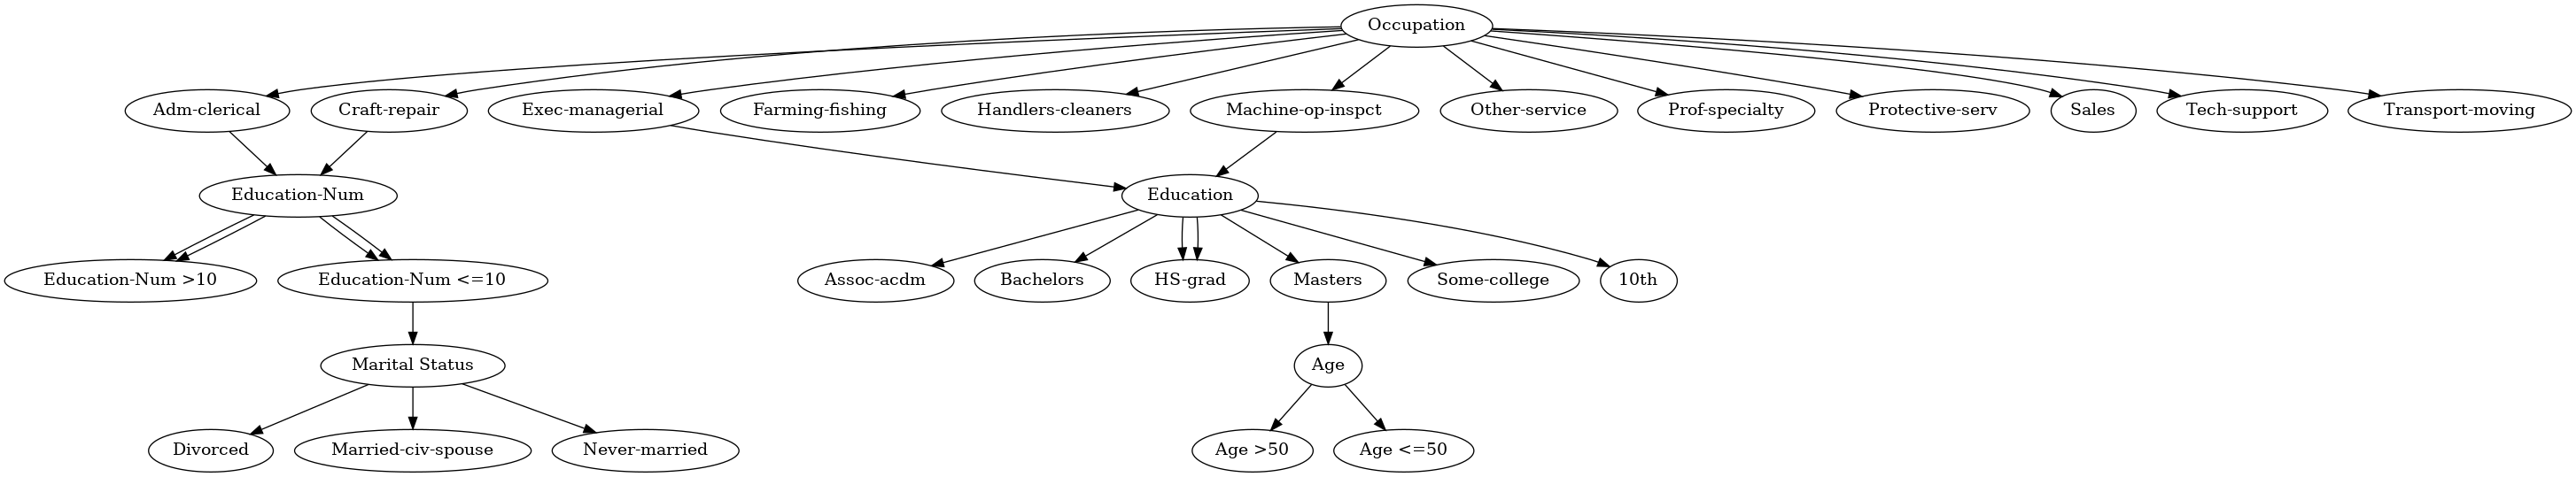

In [333]:
mostra_tree_graph(forest[4])


In [331]:
n_samples_test = 1000
test_bag = amostra_dados(test_data,n_samples_test)
values_tree = np.empty((M,2))
m=0
for tree in forest:   
    result = test_step(test_bag,tree)
    values_tree[m][0] = result[0]
    values_tree[m][1] = result[1]
    m+=1
values_forest = test_step_forest(test_bag,forest)
mean_tree = round(values_tree[:,0].mean(),4)
std_tree = round(values_tree[:,0].std(),4)
print("\n")
print(tb([['Trees', "{:.2f}".format(mean_tree)], ['Forest ', "{:.2f}".format(values_forest[0])]],
          headers=["Method", "Precision (%)"], tablefmt='orgtbl'))

YES: 0.523. NO: 0.477.
YES: 0.494. NO: 0.506.
YES: 0.588. NO: 0.412.
YES: 0.566. NO: 0.434.
YES: 0.584. NO: 0.416.
YES: 0.664. NO: 0.336.
YES: 0.63. NO: 0.37.
YES: 0.52. NO: 0.48.
YES: 0.537. NO: 0.463.
YES: 0.585. NO: 0.415.
YES: 0.87. NO: 0.13.


| Method   |   Precision (%) |
|----------+-----------------|
| Trees    |            0.57 |
| Forest   |            0.87 |


In [332]:
mean_tree = round(values_tree[:,0].mean(),4)
std_tree = round(values_tree[:,0].std(),4)
print("\n")
print(tb([['Trees', "{:.2f}".format(mean_tree)], ['Forest ', "{:.2f}".format(values_forest[0])]],
          headers=["Method", "Precision (%)"], tablefmt='orgtbl'))



| Method   |   Precision (%) |
|----------+-----------------|
| Trees    |            0.57 |
| Forest   |            0.87 |
